In [1]:
#Importing Packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)
%matplotlib inline

import sys
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import data, io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

from mpl_toolkits.axes_grid1 import ImageGrid

from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


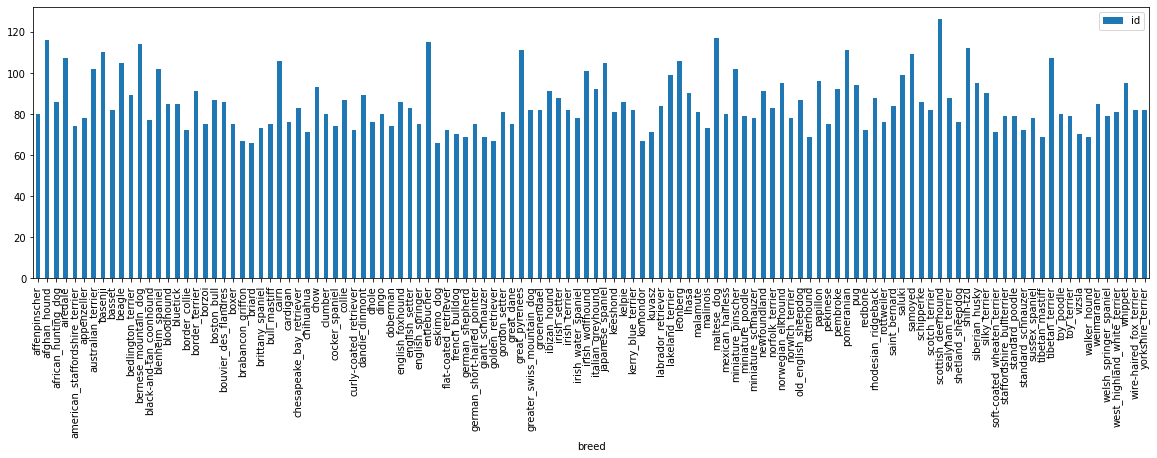

In [3]:
#read ordered labels from CSV file 
labels = pd.read_csv("/content/drive/Shared drives/Deep Learning Final Project/Data/dog-breed-identification.zip (Unzipped Files)/labels.csv")
coun = labels.groupby('breed').count()
coun.plot(kind = 'bar', figsize = (20, 5))

In [4]:
# Find 20 categories with 100 image or above
img100 = coun['id'].sort_values(ascending = False)[0:20]
img100_idx = img100.index.sort_values()
print("Total images number of 20 categories with 100 images or above:\n", img100.sum())
print("\n 20 categories with 100 images or above:\n", img100_idx)

Total images number of 20 categories with 100 images or above:
 2184

 20 categories with 100 images or above:
 Index(['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle',
       'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher',
       'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg',
       'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed',
       'scottish_deerhound', 'shih-tzu', 'tibetan_terrier'],
      dtype='object', name='breed')


In [5]:
# Identify the filenames for these 20 categories
sub_data = labels[labels['breed'].isin(img100_idx)]
img100_id = sub_data['id']
print(sub_data.head())

                                  id               breed
8   003df8b8a8b05244b1d920bb6cf451f9             basenji
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
12  00693b8bc2470375cc744a6391d397ec         maltese_dog
29  00bee065dcec471f26394855c5c2f3de               cairn
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier


In [6]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [7]:
# Create a list containing all the selected files and their directories
path = '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/'
img100_files = [path+i+'.jpg' for i in img100_id]
img100_files[0:5]

['/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00693b8bc2470375cc744a6391d397ec.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/00bee065dcec471f26394855c5c2f3de.jpg',
 '/content/drive/My Drive/Deep Learning Project/Data/dog-breed-identification.zip (Unzipped Files)/train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg']


#### Load images

In [ ]:
# Load images
imgs = []
for pic in img100_files[0:]:
  img = io.imread(pic)
  imgs.append(img)

images = np.asarray(imgs)

In [ ]:
plt.imshow(images[0])

### Resize the images and prepare for mode

In [ ]:
# Find the resize shape (we have to resize all images to the smallest image dims in the file)
IMG_RDIM = min([images[j].shape[0] for j in range(images.shape[0])])
IMG_CDIM = min([images[k].shape[1] for k in range(images.shape[0])])
IMG_RGB = min([images[l].shape[2] for l in range(images.shape[0])])
print(IMG_RDIM, IMG_CDIM, IMG_RGB)

IMG_DIM = min(IMG_RDIM, IMG_CDIM)
print(IMG_DIM)

In [ ]:
# Resize the shape and prepare data for model 
images_resized = []

for i in images:
  img_resized = resize(i, (224,224,3))
  images_resized.append(img_resized)

images_resized = np.asarray(images_resized)

In [ ]:
images_resized.shape

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files[0:]:
  base = os.path.basename(pic)
  filename = os.path.splitext(base)[0]
  files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

#### Train test split, normalization, and generate rotated images

In [ ]:
# Split train and test
X = images_resized
y = df_labels['breed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
# input image dimensions
img_rows, img_cols = IMG_DIM, IMG_DIM

#X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (224, 224, 3)

#normalize pixel intensities
#X_train /= 255
#X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [ ]:
#test_labels = y_test

# Create binarized labels for training
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')
y_train[0]

(1528, 20) train labels
(656, 20) test labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

###Using Pretrained vgg-19

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [ ]:
model_VGG19 = applications.VGG19(weights = "imagenet", include_top=False, input_shape =  (224,224,3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers which you don't want to train. 
for layer in model_VGG19.layers[:4]:
    layer.trainable = False

#Adding custom Layers 
vgg19 = model_VGG19.output
vgg19 = Flatten()(vgg19)
vgg19 = Dense(1024, activation="relu")(vgg19)
vgg19 = Dropout(0.5)(vgg19)
vgg19 = Dense(1024, activation="relu")(vgg19)
vgg19 = Dropout(0.5)(vgg19)
predictionsvgg19 = Dense(20, activation="softmax")(vgg19)

# creating the final model 
vgg19_24243 = Model(inputs = model_VGG19.input, outputs = predictionsvgg19)

In [ ]:
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

vgg19_24243.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history_vgg19_24243 = vgg19_24243.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/200
48/47 [==============================] - 24s 498ms/step - loss: 3.2773 - accuracy: 0.0471 - val_loss: 3.0069 - val_accuracy: 0.0564
Epoch 2/200
48/47 [==============================] - 22s 457ms/step - loss: 3.0794 - accuracy: 0.0569 - val_loss: 2.9835 - val_accuracy: 0.0716
Epoch 3/200
48/47 [==============================] - 22s 466ms/step - loss: 3.0333 - accuracy: 0.0537 - val_loss: 2.9740 - val_accuracy: 0.0899
Epoch 4/200
48/47 [==============================] - 22s 467ms/step - loss: 3.0310 - accuracy: 0.0602 - val_loss: 2.9716 - val_accuracy: 0.0960
Epoch 5/200
48/47 [==============================] - 22s 461ms/step - loss: 3.0142 - accuracy: 0.0596 - val_loss: 2.9771 - val_accuracy: 0.0869
Epoch 6/200
48/47 [==============================] - 22s 455ms/step - loss: 2.9958 - accuracy: 0.0668 - val_loss: 2.9789 - val_accuracy: 0.0762
Epoch 7/200
48/47 [==============================] - 22s 454ms/step - loss: 2.9909 - accuracy: 0.0602 - val_loss: 2.9694 - val_accuracy:

Text(0.5, 1.0, 'Accuracy Curves VGG19')

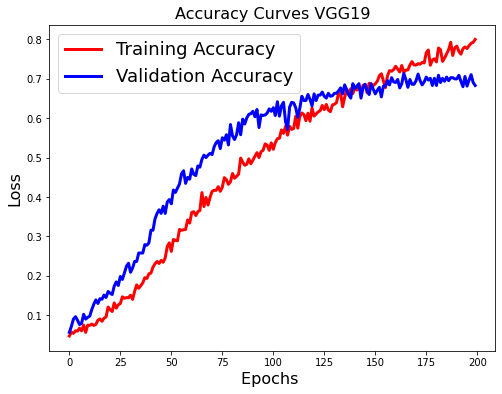

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_24243 .history['accuracy'],'r',linewidth=3.0)
plt.plot(history_vgg19_24243 .history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Accuracy Curves VGG19',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

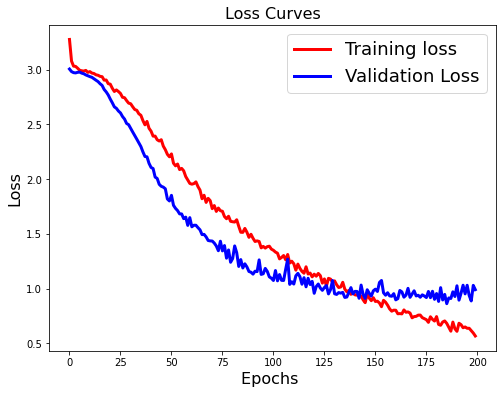

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_24243.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg19_24243.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
vgg19_24243.save('vgg19_24243.h5')

### Predicting labels

In [ ]:
predicted_classes_vgg19 = np.round_(vgg19_24243.predict(X_test),0)

In [ ]:
pre_c_list=[]
act_c_list=[]
correct_indices =[]
incorrect_indices = []

for i in range(len(y_test)):
  pred_c = np.argwhere(predicted_classes_vgg19[i]==1)
  act_c = np.argwhere(y_test[i]==1)
  if pred_c == act_c:
    correct_indices.append(i)
  else:
    incorrect_indices.append(i)
    
  pre_c_list.append(pred_c)
  act_c_list.append(act_c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


Correct Prediction


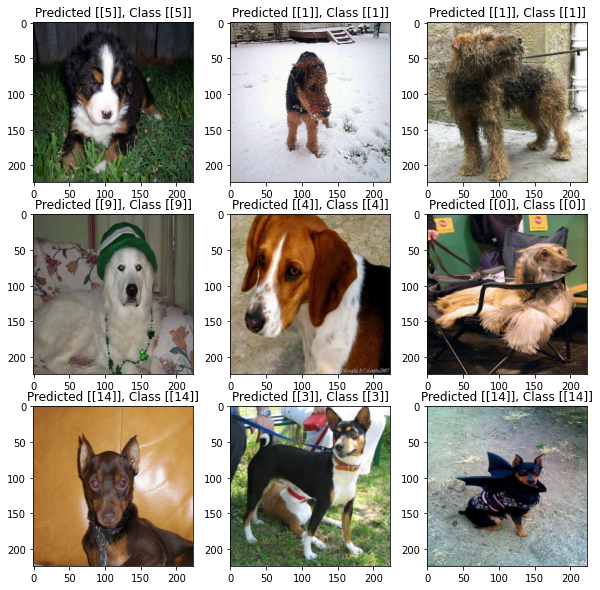

In [ ]:
#some of the correct results
print('Correct Prediction')
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct])
    plt.title("Predicted {}, Class {}".format(pre_c_list[correct], act_c_list[correct]))

Incorrect Prediction


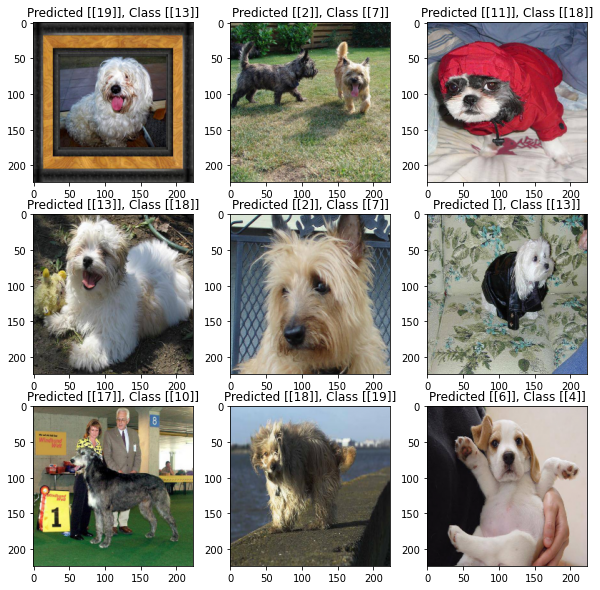

In [ ]:
print('Incorrect Prediction')
#some of the incorrect predictions
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect])
    plt.title("Predicted {}, Class {}".format(pre_c_list[incorrect], act_c_list[incorrect]))

### Training VGG19 on (97,97,3)

In [ ]:
# Resize the shape and prepare data for model 
images_resized = []

for i in images:
  img_resized = resize(i, (97,97,3))
  images_resized.append(img_resized)

images_resized = np.asarray(images_resized)

In [ ]:
images_resized.shape

(2184, 97, 97, 3)

In [ ]:
# Prepare labels data for model
# We can use sub_data['breed] for labels. However in order to make sure the filenames and the breed are matched, we will cross check this.

# Get the filenames for photoes in img100_files
import os
files = []
for pic in img100_files[0:]:
  base = os.path.basename(pic)
  filename = os.path.splitext(base)[0]
  files.append(filename)

df_files = pd.DataFrame(files, columns = ['id'])

In [ ]:
# Get the breed information based on the filenames
df_labels = df_files.merge(labels, how = 'left', on = 'id')
df_labels.shape

(2184, 2)

#### Train test split, normalization, and generate rotated images

In [ ]:
# Split train and test
X = images_resized
y = df_labels['breed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2184, 97, 97, 3) (2184,)
(1528, 97, 97, 3) (656, 97, 97, 3)
(1528,) (656,)


In [ ]:
# input image dimensions
img_rows, img_cols = IMG_DIM, IMG_DIM

#X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (224, 224, 3)

#normalize pixel intensities
#X_train /= 255
#X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1528, 97, 97, 3)
1528 train samples
656 test samples


In [ ]:
#test_labels = y_test

# Create binarized labels for training
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')
y_train[0]

(1528, 20) train labels
(656, 20) test labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

###Using Pretrained vgg-19

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [ ]:
model_VGG19_973 = applications.VGG19(weights = "imagenet", include_top=False, input_shape =  (97,97,3))

In [ ]:
# Freeze the layers which you don't want to train. 
for layer in model_VGG19_973.layers[:15]:
    layer.trainable = False

#Adding custom Layers 
vgg19 = model_VGG19_973.output
vgg19 = Flatten()(vgg19)
vgg19 = Dense(1024, activation="relu")(vgg19)
vgg19 = Dropout(0.5)(vgg19)
vgg19 = Dense(1024, activation="relu")(vgg19)
vgg19 = Dropout(0.5)(vgg19)
predictionsvgg19 = Dense(20, activation="softmax")(vgg19)

# creating the final model 
vgg19_97973 = Model(inputs = model_VGG19_973.input, outputs = predictionsvgg19)

In [ ]:
epochs = 250
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

vgg19_97973.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history_vgg19_97973 = vgg19_97973.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/250
48/47 [==============================] - 5s 106ms/step - loss: 3.3289 - accuracy: 0.0458 - val_loss: 3.0117 - val_accuracy: 0.0427
Epoch 2/250
48/47 [==============================] - 5s 101ms/step - loss: 3.1322 - accuracy: 0.0524 - val_loss: 3.0037 - val_accuracy: 0.0427
Epoch 3/250
48/47 [==============================] - 5s 100ms/step - loss: 3.0824 - accuracy: 0.0589 - val_loss: 2.9969 - val_accuracy: 0.0503
Epoch 4/250
48/47 [==============================] - 5s 101ms/step - loss: 3.0391 - accuracy: 0.0576 - val_loss: 2.9939 - val_accuracy: 0.0610
Epoch 5/250
48/47 [==============================] - 5s 101ms/step - loss: 3.0545 - accuracy: 0.0556 - val_loss: 2.9889 - val_accuracy: 0.0457
Epoch 6/250
48/47 [==============================] - 5s 101ms/step - loss: 3.0393 - accuracy: 0.0589 - val_loss: 2.9846 - val_accuracy: 0.0503
Epoch 7/250
48/47 [==============================] - 5s 101ms/step - loss: 3.0350 - accuracy: 0.0615 - val_loss: 2.9809 - val_accuracy: 0.0549

Text(0.5, 1.0, 'Accuracy Curves VGG19_(97,97,3)')

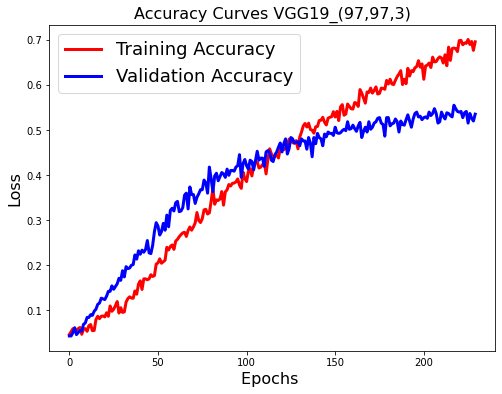

In [ ]:
 plt.figure(figsize=[8,6])
plt.plot(history_vgg19_97973 .history['accuracy'],'r',linewidth=3.0)
plt.plot(history_vgg19_97973 .history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Accuracy Curves VGG19_(97,97,3)',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

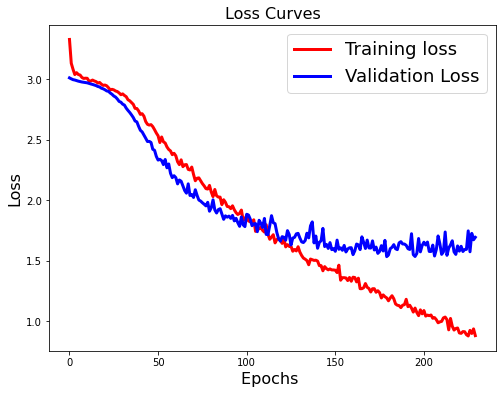

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history_vgg19_97973.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg19_97973.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
vgg19_97973.save('vgg19_97973.h5')

### Predicting labels

In [ ]:
70%-80% predicted_classes_vgg19 = np.round_(vgg19_97973.predict(X_test),0)

SyntaxError: ignored

In [ ]:
pre_c_list=[]
act_c_list=[]
correct_indices =[]
incorrect_indices = []

for i in range(len(y_test)):
  pred_c = np.argwhere(predicted_classes_vgg19[i]==1)
  act_c = np.argwhere(y_test[i]==1)
  if pred_c == act_c:
    correct_indices.append(i)
  else:
    incorrect_indices.append(i)
    
  pre_c_list.append(pred_c)
  act_c_list.append(act_c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


Correct Prediction


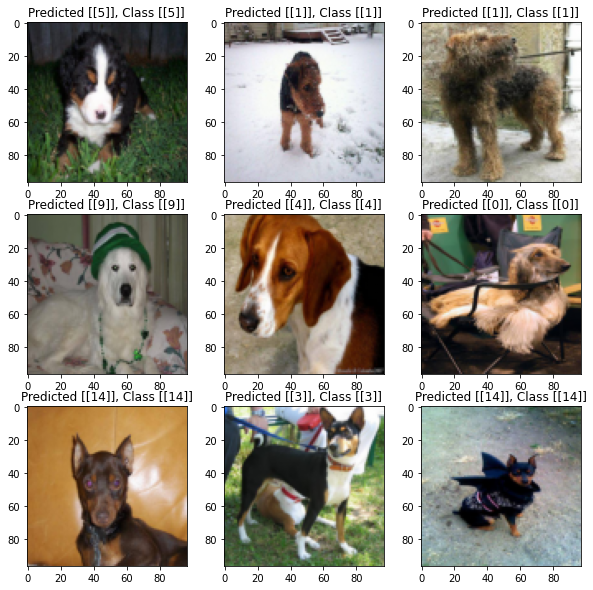

In [ ]:
#some of the correct results
print('Correct Prediction')
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct])
    plt.title("Predicted {}, Class {}".format(pre_c_list[correct], act_c_list[correct]))

Incorrect Prediction


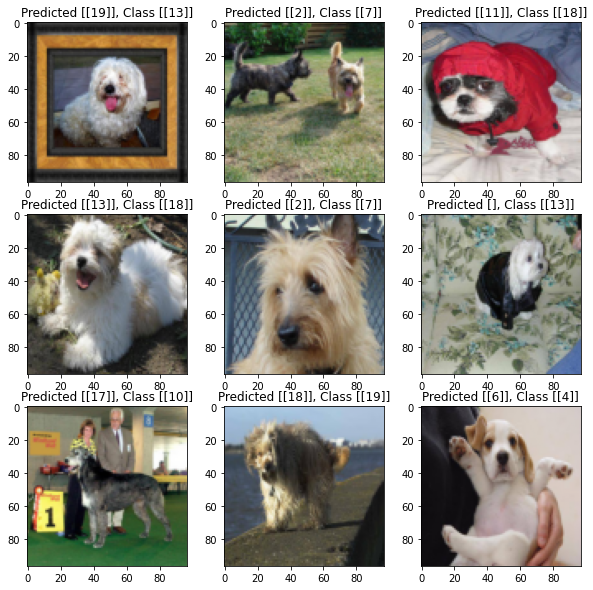

In [ ]:
print('Incorrect Prediction')
#some of the incorrect predictions
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect])
    plt.title("Predicted {}, Class {}".format(pre_c_list[incorrect], act_c_list[incorrect]))